In [1]:
import numpy as np
import pylab as pl

%matplotlib inline

In [2]:
import enaml

with enaml.imports():
    from psi.application.io import pika
    from psi.controller.util import acquire
    from psi.controller.calibration import FlatCalibration
    from psi.controller.calibration.util import dbi, psd_freq, psd, phase
    from psi.controller.queue import FIFOSignalQueue
    from psi.token.primitives import chirp_factory, generate_waveform

In [13]:
calibration = FlatCalibration.as_attenuation(fixed_gain=40)
calibration.get_sf(1000, 0)

0.01

In [3]:
input_gains_db = np.array([40, 0])[..., np.newaxis]
input_gains = dbi(input_gains_db)

In [4]:
io_manifest = pika.IOManifest()
audio_engine = io_manifest.find('NI_audio')
calibration = FlatCalibration.as_attenuation()

channel = audio_engine.hw_ai_channels[1]
audio_engine.remove_channel(channel)

ao_channel = audio_engine.hw_ao_channels[0]
ao_fs = audio_engine.hw_ao_channels[0].fs

factory = chirp_factory(ao_fs, 500, 50000, 1/50., -40, calibration=calibration)
ao_waveform = generate_waveform(factory, int(ao_fs/50.))

queue = FIFOSignalQueue(ao_fs)
queue.append(ao_waveform, trials=20, delays=0.1)

ao_channel.add_queued_epoch_output(queue)

epochs = acquire(audio_engine, queue, 1/50.+0.1)

In [5]:
ai_channel = audio_engine.hw_ai_channels[0]
ai_fs = ai_channel.fs

In [6]:
signal = np.concatenate([e['signal'][np.newaxis] for e in epochs])
#signal /= input_gains
ai_waveform = signal.mean(axis=0)

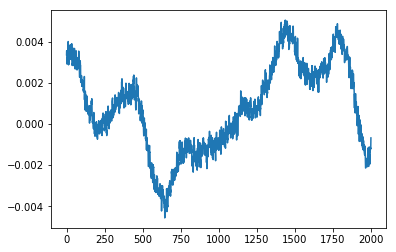

In [7]:
pl.plot(ai_waveform[:, :2000].T)

(500, 100000.0, 1e-07, 0.042081961403414338)

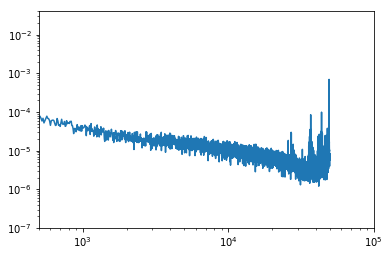

In [8]:
f = psd_freq(signal, ai_fs)
p = psd(signal, ai_fs, 'boxcar', 4)
p = p.mean(axis=0)
pl.loglog(f, p.T)
pl.axis(xmin=500, xmax=100e3, ymin=1e-7)

(100, 100000.0, -12.334332427543647, 62.638585467024214)

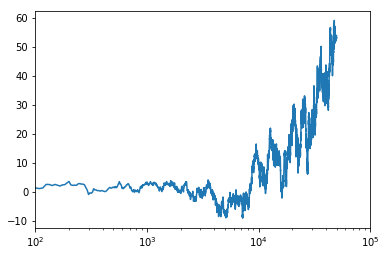

In [9]:
p = phase(signal, ai_fs, 'boxcar', 4)
p = p.mean(axis=0)
pl.semilogx(f, p.T)
pl.axis(xmin=100, xmax=100e3)